In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

from preprocessing import *
from recalibrator import Recalibrator

In [2]:
r = Recalibrator()
r.load(filename="model.pickle")

In [3]:
ab = VCF("../data/6.gencode27withflank50.vcf")
ab_lr = VCF("6recalibrated_lr.vcf")
ab_xgb = VCF("6recalibrated_xgb.vcf")

for abortus in [ab, ab_lr, ab_xgb]:
    abortus.process(0.04120035307396641, "6mo", "6fa", "6ab")
    
X = r.scaler.transform(ab.prepare_input())

/home/boi/research/ML-maternal-cell-contamination/python/preprocessing.py:196: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric=True)


In [4]:
X = r.scaler.transform(ab.prepare_input())

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
model = TSNE()
proj = model.fit_transform(X)

In [110]:
from sklearn.decomposition import PCA
proj2 = PCA(2).fit_transform(X)

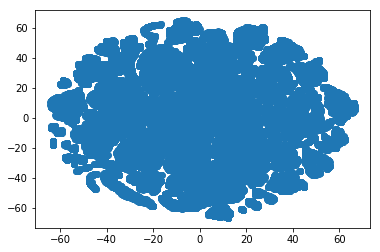

In [8]:
plt.scatter(proj[:, 0], proj[:, 1])

In [11]:
not_recal = np.logical_and(ab.df_processed['6ab^GT'].values == ab_lr.df_processed['6ab^GT'].values,
                           ab.df_processed['6ab^GT'].values == ab_xgb.df_processed['6ab^GT'].values)

recal_both = np.logical_and(ab.df_processed['6ab^GT'].values != ab_lr.df_processed['6ab^GT'].values,
                            ab.df_processed['6ab^GT'].values != ab_xgb.df_processed['6ab^GT'].values)


recal_lr = np.logical_and(ab.df_processed['6ab^GT'].values != ab_lr.df_processed['6ab^GT'].values,
                          ab.df_processed['6ab^GT'].values == ab_xgb.df_processed['6ab^GT'].values)


recal_xgb = np.logical_and(ab.df_processed['6ab^GT'].values == ab_lr.df_processed['6ab^GT'].values,
                           ab.df_processed['6ab^GT'].values != ab_xgb.df_processed['6ab^GT'].values)

# Sanity check

print("Not recalibrated: {}".format(np.sum(not_recal)))
print("Recalibrated by both: {}".format(np.sum(recal_both)))
print("Recalibrated only by LR: {}".format(np.sum(recal_lr)))
print("Recalibrated only by XGB: {}".format(np.sum(recal_xgb)))
print(np.sum(not_recal) + np.sum(recal_both) + np.sum(recal_lr) + np.sum(recal_xgb) == len(not_recal))

Not recalibrated: 65647
Recalibrated by both: 2723
Recalibrated only by LR: 9011
Recalibrated only by XGB: 420
True


In [12]:
colors = np.empty(len(not_recal), dtype=np.str)
colors[not_recal] = 'yellow'
colors[recal_both] = 'blue'
colors[recal_lr] = 'green'
colors[recal_xgb] = 'red'

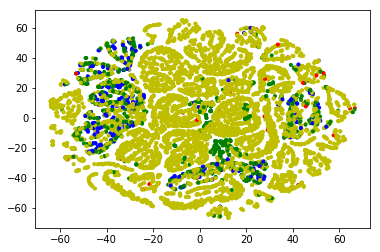

In [13]:
plt.scatter(proj[:, 0][::10], proj[:, 1][::10], c=colors[::10], marker='.')

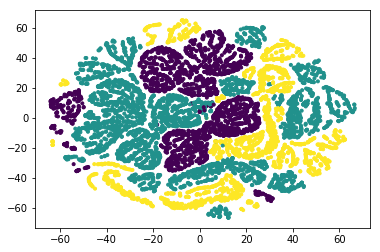

In [14]:
plt.scatter(proj[:, 0][::10], proj[:, 1][::10], c=ab.df_processed['6ab^GT'][::10], marker='.')

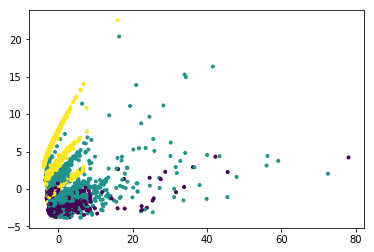

In [113]:
from sklearn.decomposition import PCA
proj2 = PCA(2).fit_transform(X)
plt.scatter(proj2[:, 0][::10], proj2[:, 1][::10], c=ab.df_processed['6ab^GT'][::10], marker='.')

In [115]:
from sklearn.manifold import LocallyLinearEmbedding
proj2 = LocallyLinearEmbedding(2).fit_transform(X)
plt.scatter(proj2[:, 0][::10], proj2[:, 1][::10], c=ab.df_processed['6ab^GT'][::10], marker='.')

ValueError: Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that method='arpack' can fail when the weight matrix is singular or otherwise ill-behaved.  method='dense' is recommended. See online documentation for more information.

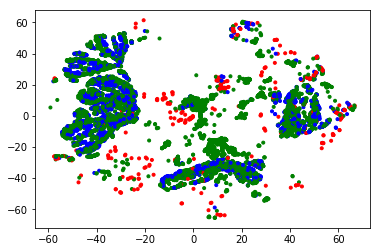

In [15]:
plt.scatter(proj[~not_recal, 0], proj[~not_recal, 1], c=colors[~not_recal], marker='.')

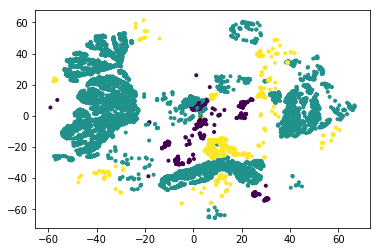

In [16]:
plt.scatter(proj[~not_recal, 0], proj[~not_recal, 1], c=ab.df_processed['6ab^GT'].values[~not_recal], marker='.')

Number of outliers: 36


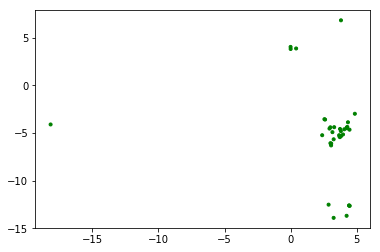

In [108]:
outliers = np.logical_and(df["#CHROM"].isin(chrs).values, df["POS"].isin(poss).values)
plt.scatter(proj[outliers, 0], proj[outliers, 1], c=colors[outliers], marker='.')
print("Number of outliers: {}".format(np.sum(outliers)))

In [35]:
r.model_lr.coef_[1]

array([ 2.69477461e-02,  1.01800702e-02,  6.39102691e-02,  3.99225169e-01,
        5.09408013e-01,  1.67842833e-01, -7.71057744e-01, -6.06103504e+00,
        2.59293793e+00, -3.39903569e+00, -1.04946237e+00, -4.52758417e-01,
       -2.22016912e-01,  6.64733855e+00, -3.32335919e+00,  4.71819057e+00,
        4.68819885e-01,  2.90643648e-01,  5.44894708e-03,  2.24405023e-01,
       -4.07396080e-01, -7.92303862e-01, -1.64994048e+00,  2.21606436e+00,
       -8.04938741e-01, -1.14046765e-01,  9.95492938e-02,  3.98904526e-03,
        8.83847107e-01, -8.17588447e-01,  7.96483825e-02, -1.13024899e+00])

In [106]:
X[outliers]@ r.model_lr.coef_[1]

array([ 0.93821022,  0.82523132,  1.74880841,  1.53200797,  0.93058516,
        1.93760873,  2.26278931, 14.02835659,  5.20381906,  1.12023513,
        1.05251808,  0.78602502,  5.89352624,  3.64256843,  3.86190532,
        0.68687683,  1.68068406,  1.15843695,  1.2987188 ,  0.39647915,
        1.10953584,  5.76688032,  1.58630676,  5.47382176,  4.29225705,
        2.59640005,  1.6849156 ,  1.71130751,  2.7735486 ,  2.72896109,
        0.936057  ,  1.97427257,  1.15145067,  2.63443599,  1.47769883,
        1.64742037])

In [66]:
np.array([X[outliers]@ r.model_lr.coef_[i] + r.model_lr.intercept_[i] for i in [0, 1, 2]]).T

array([[ -1.42931851,   0.11457346, -14.91585846],
       [ -0.70903042,  -0.43729616,  -4.85129511],
       [ -0.97032418,  -0.55027506,  -5.44905757],
       ...,
       [ -0.77061915,   1.62780643, -12.70514186],
       [ -1.28448505,  -0.45987411, -12.84626906],
       [ -2.38985028,  -0.50379893, -13.07919691]])

In [67]:
r.model_lr.decision_function(X)[ab_lr.df_processed['6ab^GT'].values == 1][:20]

array([[ -3.84589087,  -1.71785278,  -1.8454778 ],
       [ -3.15682689,   3.08088996,  -7.11904578],
       [ -9.84100585,   6.24291896,  -6.75771765],
       [-11.16252921,   7.11162101,  -6.56630767],
       [ -1.42931851,   0.11457346, -14.91585846],
       [-12.44602495,   8.07358188,  -5.86406219],
       [ -2.1113575 ,   0.158401  ,  -3.52183995],
       [ -1.61633457,   1.00468777,  -3.2057391 ],
       [ -0.67512325,  -0.08954935,  -7.24531581],
       [  0.47836784,   2.12207872,  -4.48804205],
       [ -0.57635872,  -0.02875089,  -5.02819301],
       [ -2.43541439,   0.56499928,  -2.31611619],
       [ -0.58870468,   0.84317815,  -4.27861357],
       [ -2.14035316,  -0.82475892,  -2.46632823],
       [ -0.53564645,   0.05567469,  -3.49723998],
       [ -0.83748778,   0.30202459,  -3.09621959],
       [  0.97473005,   1.41100268,  -6.56935631],
       [ -3.46285494,   0.08649638,  -2.76196632],
       [ -5.35049558,   5.43519011,  -8.53676427],
       [ -2.16666693,   1.50132

In [116]:
r.model_lr.decision_function(X[outliers])[:20]

array([[ -0.70903042,  -0.43729616,  -4.85129511],
       [ -0.97032418,  -0.55027506,  -5.44905757],
       [ -1.09567728,   0.37330203,  -3.06133862],
       [ -1.47919296,   0.15650159,  -5.33744809],
       [ -1.10842929,  -0.44492122,  -9.32000937],
       [ -0.40646253,   0.56210235,  -6.7762594 ],
       [  0.37958392,   0.88728293,  -8.53343928],
       [-20.99264213,  12.65285022,  12.46081454],
       [ -7.89404326,   3.82831268, -42.33657311],
       [ -0.3207876 ,  -0.25527124,  -4.8094429 ],
       [ -1.35998141,  -0.32298829,  -4.56447516],
       [ -1.30933398,  -0.58948136,  -5.7147744 ],
       [ -7.56911348,   4.51801987,  -0.40304294],
       [ -5.04127051,   2.26706205,  -2.29188898],
       [ -4.74697285,   2.48639894,  -3.06940513],
       [ -1.25345159,  -0.68862955,  -5.83729433],
       [ -0.72048542,   0.30517768,  -5.27372679],
       [ -2.19257236,  -0.21706943,  -3.78663473],
       [ -0.46704206,  -0.07678758,  -3.80796124],
       [ -2.53570472,  -0.97902

In [85]:
chrs = idx6.values[:, 0]
poss = idx6.values[:, 1]

In [86]:
chrs

array(['chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr2', 'chr2', 'chr3',
       'chr3', 'chr4', 'chr6', 'chr7', 'chr7', 'chr7', 'chr7', 'chr7',
       'chr7', 'chr8', 'chr8', 'chr9', 'chr10', 'chr11', 'chr11', 'chr19',
       'chr19', 'chr19', 'chr19', 'chr19', 'chr19', 'chr19', 'chr19',
       'chr19', 'chr19', 'chr19', 'chr20', 'chr21'], dtype=object)

In [87]:
poss

array([1269004, 1387726, 1390875, 109796053, 228504669, 234637707,
       234638249, 195508005, 195511214, 6303706, 106959961, 39379286,
       100549865, 100549967, 100550191, 100551799, 100679366, 7218805,
       11302044, 17302099, 81371637, 1643287, 18194944, 4511365, 4512409,
       4512613, 5866724, 10218621, 15838972, 15839081, 33490585, 43439848,
       43439970, 43579679, 1552348, 45649640], dtype=object)

In [92]:
df = index_by_chrom_and_pos(ab.df_processed)

In [97]:
df.loc[('chrM', 3506)]

#CHROM                chrM
POS                   3506
REF                      1
ALT                      3
AC                       1
AF                    0.25
6mo^GT                   0
6mo^DP                  24
6fa^GT                   1
6fa^DP                  24
6ab^GT                   0
6ab^DP                   9
6mo^PL0                  0
6mo^PL1            1.78533
6mo^PL2            2.91009
6fa^PL0            2.85491
6fa^PL1                  0
6fa^PL2            1.20412
6ab^PL0                  0
6ab^PL1            1.44716
6ab^PL2            2.49831
6mo^AD0                 24
6mo^AD1                  0
6fa^AD0                  3
6fa^AD1                 21
6ab^AD0                  9
6ab^AD1                  0
6mo^GT^0^1H           True
6mo^GT^1^1H          False
6mo^GT^2^1H          False
6fa^GT^0^1H          False
6fa^GT^1^1H           True
6fa^GT^2^1H          False
6ab^GT^0^1H           True
6ab^GT^1^1H          False
6ab^GT^2^1H          False
contamination    0.0412004
N

In [104]:
outliers = np.logical_and(df["#CHROM"].isin(chrs).values, df["POS"].isin(poss).values)

36

In [102]:
df["POS"].isin(poss).values

array([False, False, False, ..., False, False, False])